In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# os.getcwd()

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [ ]:
# path = './drive/MyDrive/...'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
# os.chdir(path)

In [ ]:
# os.getcwd()

In [6]:
train = pd.read_csv("/content/drive/MyDrive/DSL/세션자료/0804_supervised_learning/data/train.csv",encoding='CP949')
test = pd.read_csv("/content/drive/MyDrive/DSL/세션자료/0804_supervised_learning/data/test.csv",encoding='CP949')

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [8]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [9]:
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [10]:
train.rename(columns = {'전력사용량(kWh)' : 'Wh','기온(°C)':'Temp','풍속(m/s)':'Wind','습도(%)':'Moisture','강수량(mm)':'Precipitation','일조(hr)':'Sun'}, inplace = True)


In [11]:
test.rename(columns = {'전력사용량(kWh)' : 'Wh','기온(°C)':'Temp','풍속(m/s)':'Wind','습도(%)':'Moisture','강수량(mm)':'Precipitation','일조(hr)':'Sun'}, inplace = True)


In [13]:
train.drop(columns = ['비전기냉방설비운영', '태양광보유'],inplace =True)
test.drop(columns = ['비전기냉방설비운영', '태양광보유'],inplace =True)

In [14]:
train.head()

,num,date_time,Wh,Temp,Wind,Moisture,Precipitation,Sun
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0


In [7]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [77]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [16]:
parsing(train)

(        Temp  Wind  Moisture  Precipitation  Sun
 0       17.6   2.5      92.0            0.8  0.0
 1       17.7   2.9      91.0            0.3  0.0
 2       17.5   3.2      91.0            0.0  0.0
 3       17.1   3.2      91.0            0.0  0.0
 4       17.0   3.3      92.0            0.0  0.0
 ...      ...   ...       ...            ...  ...
 122395  27.8   2.3      68.0            0.0  0.7
 122396  27.3   1.2      71.0            0.0  0.0
 122397  27.3   1.8      71.0            0.0  0.0
 122398  27.1   1.8      74.0            0.0  0.0
 122399  27.1   2.6      75.0            0.0  0.0
 
 [122400 rows x 5 columns], 0         8179.056
 1         8135.640
 2         8107.128
 3         8048.808
 4         8043.624
             ...   
 122395    4114.368
 122396    3975.696
 122397    3572.208
 122398    3299.184
 122399    3204.576
 Name: Wh, Length: 122400, dtype: float64)

In [78]:
def load_data():
    data = pd.read_csv("/content/drive/MyDrive/DSL/세션자료/0804_supervised_learning/data/train.csv", encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [79]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [80]:
train_x.head()

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


In [22]:
train_y.head()

0    8179.056
1    8135.640
2    8107.128
3    8048.808
4    8043.624
Name: Wh, dtype: float64

In [ ]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
# train_x =

In [81]:
all = pd.concat([train_x,train_y],axis=1)
all

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624
...,...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6,8386.416
84,25.0,3.1,63.0,0.0,0.8,8435.664
85,26.0,3.1,60.0,0.0,1.0,8591.184
86,26.4,3.8,60.0,0.0,1.0,8638.488


In [82]:
corr = all.corr()
corr

,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


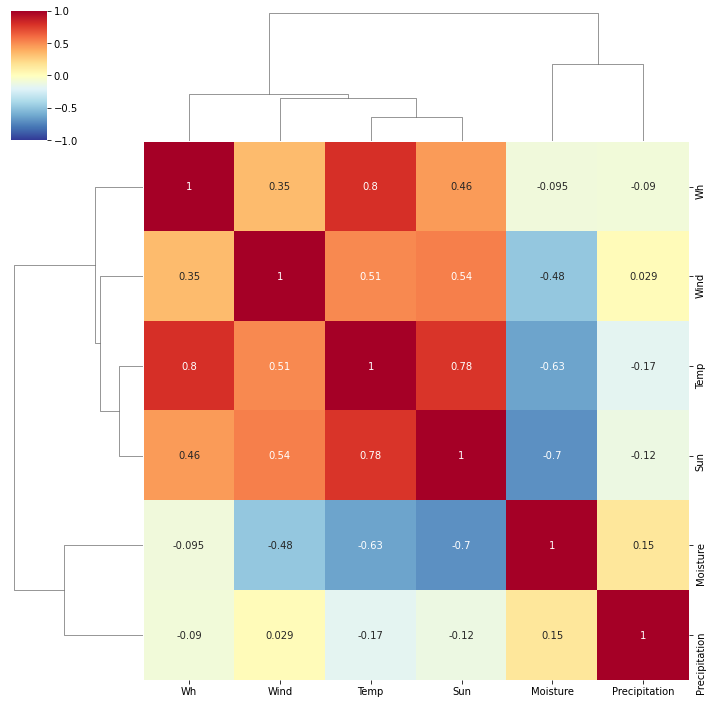

In [83]:
sns.clustermap(corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : correlation matrix 를 그려봤을때 Wh 와 상관관계가 가장 높은것은 Temp 였다. 따라서 Temp를 최종변수로 선택했다.

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    all.values, i) for i in range(all.shape[1])]
vif["features"] = all.columns
vif

,VIF Factor,features
0,177.917989,Temp
1,10.717403,Wind
2,57.056530,Moisture
3,1.093820,Precipitation
4,4.993713,Sun
5,308.947152,Wh


In [87]:
train_x = train_x.iloc[:,0]
test_x = test_x.iloc[:,0]

In [94]:
train_x = train_x.to_numpy()[:, np.newaxis]
test_x = test_x.to_numpy()[:,np.newaxis]

In [95]:
train_x.shape

(88, 1)

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [112]:
# 사용할 패키지를 import! StandardScler 사용
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_x_std = standard_scaler.fit_transform(train_x)
test_x_std = standard_scaler.transform(test_x)


In [97]:
train_x_std.shape

(88, 1)

In [98]:
train_y.shape

(88,)

In [39]:
test_x_std.shape

(12, 4)

In [107]:
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

In [109]:
train_y.shape

(88,)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [113]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_x_std, train_y)

LinearRegression()

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [114]:
esti_y = model.predict(train_x_std)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [101]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [115]:
train_mse = mse(esti_y, train_y)
train_mse
#print(f"Linear {train_mse:}",train_mse)

14543.758279391448

In [116]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

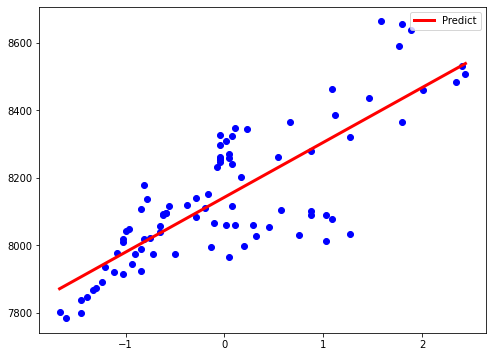

In [118]:
# visualization 하실 분은 진행해주세요!
visualize(model, train_x_std, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [ ]:
# transform을 하시는 분들은 실행해주세요
# test_x = 

In [119]:
# y1_hat에 predict값 할당
# pred_y = 
pred_y = model.predict(test_x_std)


# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [120]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [121]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 198060.52184


In [122]:
score(train_mse,test_mse)

 13.6182


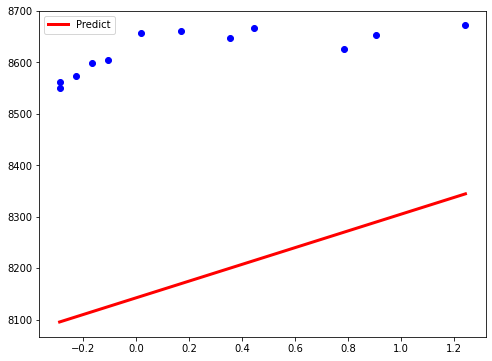

In [125]:
# visualization 하실 분은 진행해주세요!
visualize(model, test_x_std, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!